<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 14 - Multi-layer perceptrons
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

Things to discuss in this lecture: 

- Construction of multi-layer networks
- Alternate activation functions to improve capabilities
- Creating multi-layer perceptrons in PyTorch


## Limits of Logistic Regression

We have demonstrated how logistic regression paired with the softmax function enables us to perform multi-class classification. Through toy datasets in the previous lectures and the MNIST dataset in the homework, we have shown that logistic regression is highly effective in many problem settings. Recall that we can define a multi-class logistic regression model as performing a matrix-vector multiplication with an input vector $x\in\mathbb{R}^N$ to produce class scores $z\in\mathbb{R}^M$.

$$
\begin{align}
z &= Wx+b\\
&= \begin{bmatrix}
\rule[.6ex]{4ex}{0.75pt} & w_1^\top & \rule[.6ex]{4ex}{0.75pt}\\
\rule[.6ex]{4ex}{0.75pt} & w_2^\top & \rule[.6ex]{4ex}{0.75pt}\\
& \vdots & \\
\rule[.6ex]{4ex}{0.75pt} & w_M^\top & \rule[.6ex]{4ex}{0.75pt}\\
\end{bmatrix}\begin{bmatrix}
\rule[-1ex]{0.5pt}{4ex}\\
x\\
\rule[1ex]{0.5pt}{4ex}\\
\end{bmatrix}
+\begin{bmatrix}
b_1\\
b_2\\
\vdots\\
b_M
\end{bmatrix}\\
&= \begin{bmatrix}
z_1\\
z_2\\
\vdots\\
z_M
\end{bmatrix}
\end{align}
$$

In PyTorch, we can efficiently implement the multi-class logistic regression model using the [``nn.Linear`` class](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) which implements parameter matrices including bias terms. The resulting class scores are then converted to class probabilities using the softmax function.

$$
\textrm{softmax}(z)_k=\mathbf{Pr}\{\textrm{Class }y=k|x\} = \frac{e^{z_k}}{\sum_{j=1}^{M}e^{z_j}}.
$$

Let's now consider another toy dataset known as the two moons dataset and see how logistic regression performs on this data.

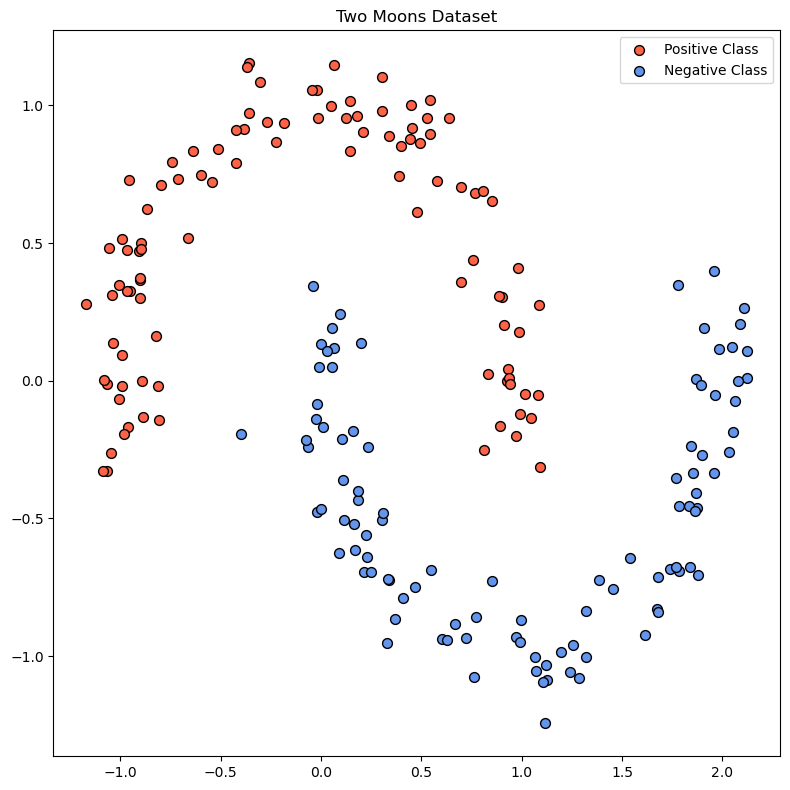

In [31]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class TwoMoonsDataset(Dataset):
    def __init__(self, sigma, N):
        self.sigma = sigma
        self.N = N
        self.radius = 1
        self.angle_offset = -np.pi/8
        self.positive_center = torch.tensor([0, 0])
        self.negative_center = torch.tensor([1, 0])
        # generate angles of each moon
        positive_angles = torch.rand(N)*(np.pi-2*self.angle_offset)+self.angle_offset
        negative_angles = torch.rand(N)*(np.pi-2*self.angle_offset)+self.angle_offset
        # generate each moon
        self.positive_data = self.positive_center + torch.stack((self.radius*torch.cos(positive_angles),
                                                                 self.radius*torch.sin(positive_angles)), dim=-1)
        self.positive_data = self.positive_data + torch.randn(N, 2)*sigma
        self.negative_data = self.negative_center + torch.stack((self.radius*torch.cos(-negative_angles),
                                                                 self.radius*torch.sin(-negative_angles)), dim=-1)
        self.negative_data = self.negative_data + torch.randn(N, 2)*sigma
        # wrap up all data and labels
        self.data = torch.cat((self.positive_data, self.negative_data), dim=0)
        self.labels = torch.cat((torch.ones(N), torch.zeros(N))).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class MulticlassLogisticRegression(nn.Module):
    def __init__(self, N, M):
        super().__init__()
        self.N = N # input dimension
        self.M = M # number of classes
        self.weight_matrix = nn.Linear(N, M, bias=True) # N input dimensions, M output dimensions

    def forward(self, x):
        return self.weight_matrix(x)

def plot_model_probs(model, plus_class, negative_class):
    x = torch.linspace(-2, 3, 100)
    y = torch.linspace(-2, 2, 100)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    meshgrid_inputs = torch.stack((X.flatten(), Y.flatten()), dim=1)
    with torch.no_grad():
        meshgrid_outputs = torch.softmax(model(meshgrid_inputs), dim=1)[:, 1]

    plt.figure(figsize=(8, 6))
    plt.contourf(X.numpy(), Y.numpy(), meshgrid_outputs.reshape(100, 100).numpy(), cmap='RdBu_r', levels=100)
    plt.colorbar()
    plt.title('Probability of positive class')
    plt.scatter(plus_class[:, 0].numpy(), plus_class[:, 1].numpy(), color='tomato', s=50, edgecolor='black')
    plt.scatter(negative_class[:, 0].numpy(), negative_class[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black')
    plt.axis(False)
    plt.tight_layout()

def plot_model_probs_with_component_lines(model, plus_class, negative_class, W, b, layers):
    x = torch.linspace(-2, 3, 100)
    y = torch.linspace(-2, 2, 100)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    meshgrid_inputs = torch.stack((X.flatten(), Y.flatten()), dim=1)
    with torch.no_grad():
        meshgrid_outputs = torch.softmax(model(meshgrid_inputs), dim=1)[:, 1]

    plt.figure(figsize=(8, 6))
    plt.contourf(X.numpy(), Y.numpy(), meshgrid_outputs.reshape(100, 100).numpy(), cmap='RdBu_r', levels=100)
    plt.colorbar()
    plt.title('Probability of positive class')
    plt.scatter(plus_class[:, 0].numpy(), plus_class[:, 1].numpy(), color='tomato', s=50, edgecolor='black')
    plt.scatter(negative_class[:, 0].numpy(), negative_class[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black')
    plt.axis(False)
    plt.tight_layout()
    
    # Plot the hidden layer linear decision boundaries
    #W = model.weight_matrix1.weight.detach().numpy()  # Shape: (L, 2)
    #b = model.weight_matrix1.bias.detach().numpy()    # Shape: (L,)

    x_vals = np.linspace(-2, 3, 200)
    for i in range(layers):
        w = W[i]
        bias = b[i]
        # Line equation: w0 * x + w1 * y + b = 0 ⟹ y = (-w0 * x - b) / w1
        if np.abs(w[1]) > 1e-6:  # avoid division by zero
            y_vals = (-w[0] * x_vals - bias) / w[1]
            plt.plot(x_vals, y_vals, linestyle='--', color='black', alpha=0.5)
    
    plt.xlim(-2, 3)
    plt.ylim(-2, 2)    
    
def multiclass_model_accuracy(model, input_data, labels):
    predictions = model(input_data) # no need to squeeze/unsqueeze dimensions now!
    predicted_classes = torch.argmax(predictions, dim=1) # find highest scoring class along the columns
    n_correct = torch.sum(torch.eq(predicted_classes, labels))
    return n_correct

def print_model_params(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)


# visualize example of two moons dataset
N = 100
sigma = 0.1
dataset = TwoMoonsDataset(sigma, N)
plus_data = dataset.positive_data
negative_data = dataset.negative_data
plt.figure(figsize=(8, 8))
plt.scatter(plus_data[:, 0].numpy(), plus_data[:, 1].numpy(), color='tomato', s=50, edgecolor='black', label='Positive Class')
plt.scatter(negative_data[:, 0].numpy(), negative_data[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black', label='Negative Class')
plt.title('Two Moons Dataset')
plt.legend()
plt.tight_layout()

Now, let's try training a logistic regression model on this data. For the purposes of this exercise, we will not worry about creating separate training, validation, and testing splits.

Let's recap on what our logistic perceptron move is visually: 

<img align="center" src="img/single_logistic_perceptron.png" width="600px" style="padding:30px;border:thin solid white;"> 


Text(0, 0.5, 'Accuracy')

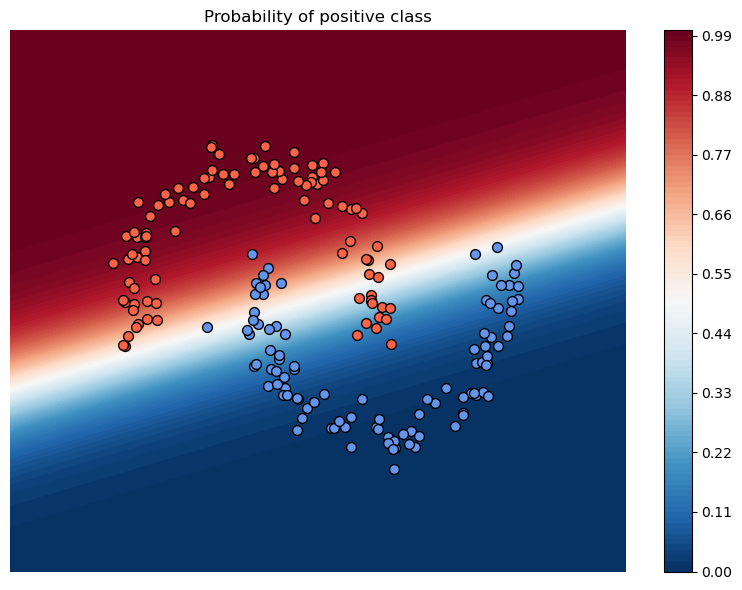

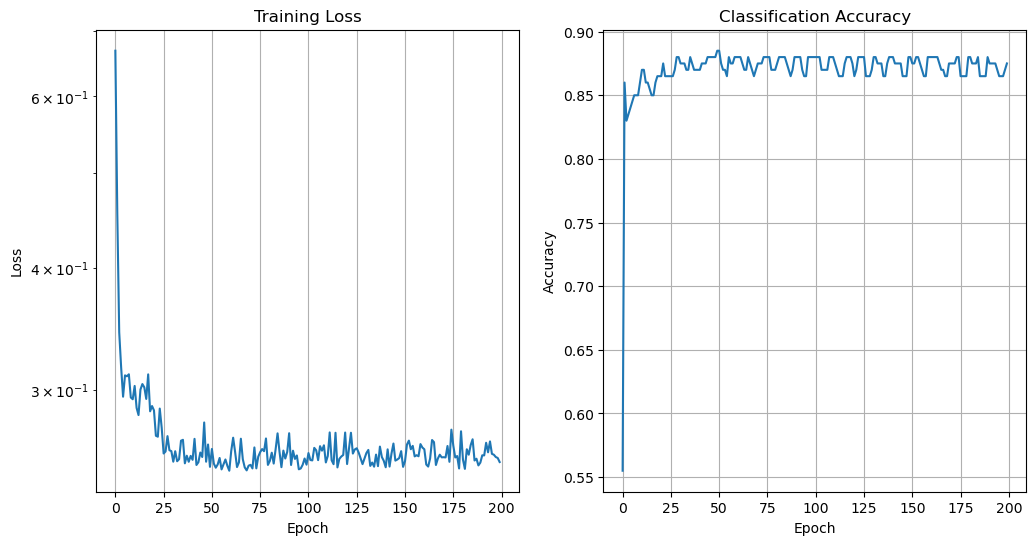

In [32]:
# loss function, model, and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean') # cross-entropy loss, use mean of loss
lr = 1e-2 # learning rate
M = 2 # two classes
N = 2 # data is two-dimensional
model = MulticlassLogisticRegression(M, N)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-3) 

# create training dataloader
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# training loop
n_epoch = 200
loss_values, accuracies = [], []
for n in range(n_epoch):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # zero out gradients
        optimizer.zero_grad()
        # pass batch to model
        predictions = model(x_batch)
        # calculate loss
        loss = criterion(predictions, y_batch)
        # backpropagate and update
        loss.backward() # backprop
        optimizer.step()
        # logging to update epoch_loss (add loss value) and epoch_acc (add current batch accuracy)
        epoch_loss += loss.item()
        epoch_acc += multiclass_model_accuracy(model, x_batch, y_batch)
    loss_values.append(epoch_loss/len(train_loader))
    accuracies.append(epoch_acc/len(dataset))
    
# plot model probabilities
plot_model_probs(model, dataset.positive_data, dataset.negative_data)
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

weight_matrix.weight tensor([[ 0.6106, -2.2457],
        [-0.6192,  2.2808]])
weight_matrix.bias tensor([-0.2708,  0.2180])


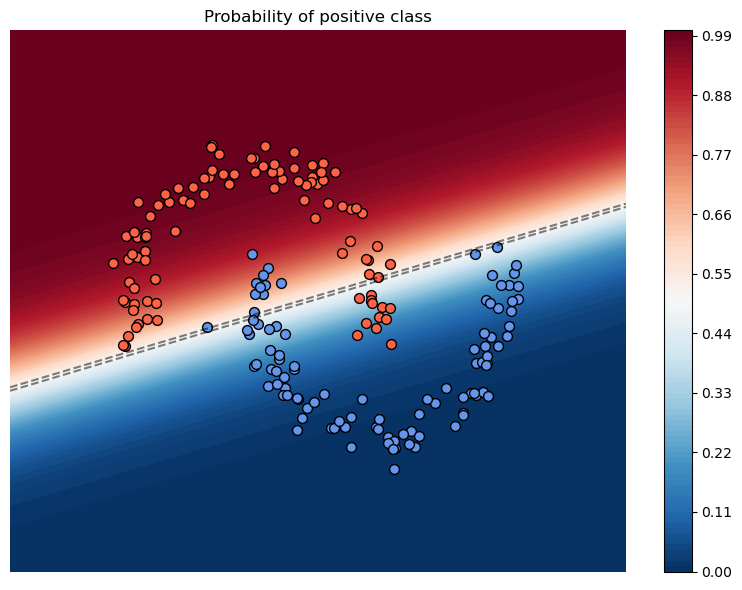

In [33]:
plot_model_probs_with_component_lines(model, dataset.positive_data, dataset.negative_data, model.weight_matrix.weight.detach().numpy(), model.weight_matrix.bias.detach().numpy(), 2)
print_model_params(model)

The provided two moons dataset is clearly separable by some curvy line, thus we should be able to find some representation for the class boundary that perfectly separates the two classes. However, logistic regression is incapable of performing this separation because the weights of a logistic regression model parameterize a straight line or hyperplane class boundary. In other words, we can only achieve linear class boundaries with logistic regression while this toy dataset requires a non-linear class boundary.

## How can we represent more complex functions?

We would like to implement barriers that aren't just straight lines, but are also curves. So let's forget training for a moment and try to figure out how to create a curved barrier: 

In [47]:
class MulticlassLogisticRegression_Test1(nn.Module):
    def __init__(self):
        super().__init__()
        self.N = 2  # input dimension
        self.M = 2  # number of classes
        self.weight_matrix = nn.Linear(N, M, bias=True)

        # Set custom initial weights and biases
        custom_weights_1 = torch.tensor([[-0.6106, -2.2457],
                                       [ 0.6192,  2.2808]])
        custom_biases_1 = torch.tensor([0.2708,  0.2180])

        custom_weights_2 = torch.tensor([[0.6106, -2.2457],
                                       [ -0.6192,  2.2808]])
        custom_biases_2 = torch.tensor([-0.2708,  0.2180])

        with torch.no_grad():
            self.weight_matrix.weight.copy_(custom_weights_1)
            self.weight_matrix.bias.copy_(custom_biases_1)

    def forward(self, x):
        return self.weight_matrix(x)

weight_matrix.weight tensor([[-0.6106, -2.2457],
        [ 0.6192,  2.2808]])
weight_matrix.bias tensor([0.2708, 0.2180])


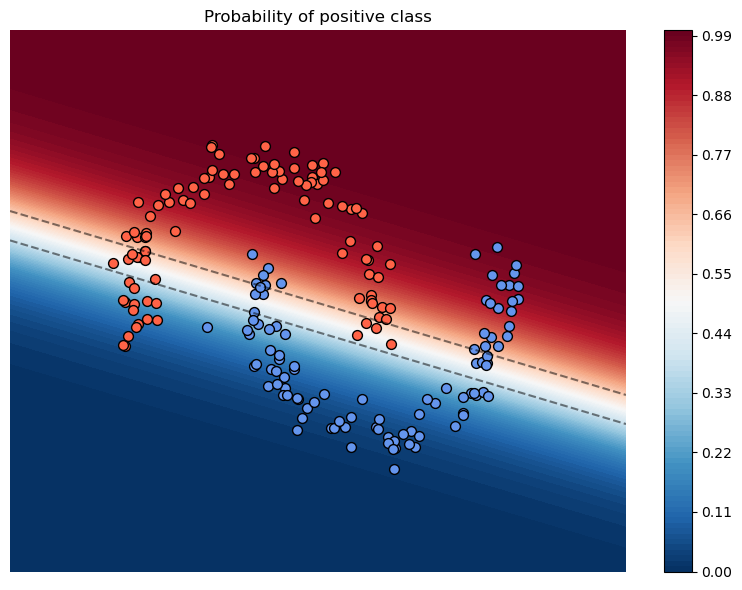

In [48]:
model_test = MulticlassLogisticRegression_Test1()
plot_model_probs_with_component_lines(model_test, dataset.positive_data, dataset.negative_data, model_test.weight_matrix.weight.detach().numpy(), model_test.weight_matrix.bias.detach().numpy(), 2)
print_model_params(model_test)

In [51]:
print(model_test(torch.tensor([1.0,1.0])))

tensor([-2.5855,  3.1180], grad_fn=<ViewBackward0>)


What if we try to combine multiple linear separation planes? Can that give us the curvature we want? 

<img align="center" src="img/multi_logistic_perceptron.png" width="600px" style="padding:30px;border:thin solid white;"> 


In [58]:
class MulticlassLogisticRegression_Test2(nn.Module):
    def __init__(self):
        super().__init__()
        self.N = 2  # input dimension
        self.M = 2  # number of classes
        self.weight_matrix = nn.Linear(N, 2, bias=True)
        self.weight_matrix_2 = nn.Linear(2, M, bias=True)
        
        # Set custom initial weights and biases
        custom_weights_1 = torch.tensor([[-0.6106, -2.2457],
                                         [ 0.6106, -2.2457]])
        custom_biases_1 = torch.tensor([0.2708,  -0.2708])

        # Set custom initial weights and biases
        custom_weights_2 = torch.tensor([[1, 1],
                                         [ -1, -1]])
        custom_biases_2 = torch.tensor([0.0,  0.0])

        
        with torch.no_grad():
            self.weight_matrix.weight.copy_(custom_weights_1)
            self.weight_matrix.bias.copy_(custom_biases_1)
            self.weight_matrix_2.weight.copy_(custom_weights_2)
            self.weight_matrix_2.bias.copy_(custom_biases_2)

    def forward(self, x):
        x = self.weight_matrix(x)
        x = torch.nn.functional.relu(x)
        z = self.weight_matrix_2(x)
        return z
        #return self.weight_matrix_1(x)

weight_matrix.weight tensor([[-0.6106, -2.2457],
        [ 0.6106, -2.2457]])
weight_matrix.bias tensor([ 0.2708, -0.2708])
weight_matrix_2.weight tensor([[ 1.,  1.],
        [-1., -1.]])
weight_matrix_2.bias tensor([0., 0.])


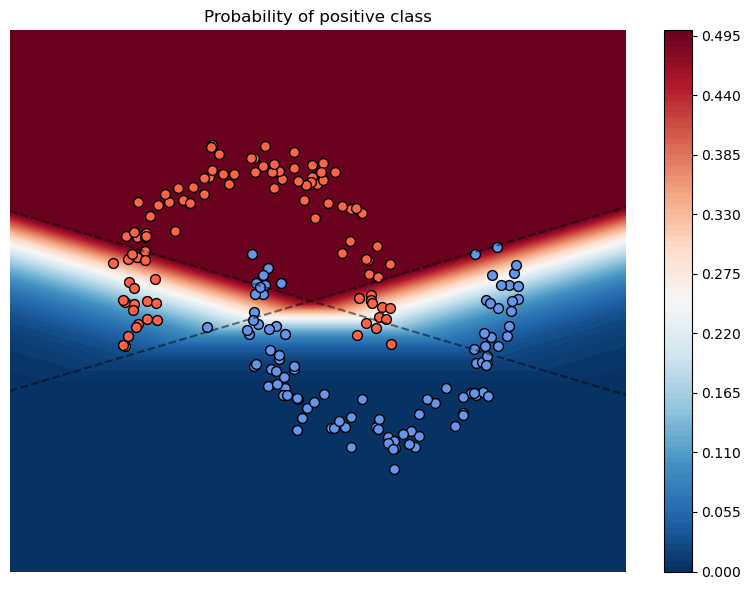

In [63]:
model_test = MulticlassLogisticRegression_Test2()
plot_model_probs_with_component_lines(model_test, dataset.positive_data, dataset.negative_data, model_test.weight_matrix.weight.detach().numpy(), model_test.weight_matrix.bias.detach().numpy(), 2)
print_model_params(model_test)

## What's with the ReLU? 

Well let's try without ReLu real quick: 

In [60]:
class MulticlassLogisticRegression_Test3(nn.Module):
    def __init__(self):
        super().__init__()
        self.N = 2  # input dimension
        self.M = 2  # number of classes
        self.weight_matrix = nn.Linear(N, 2, bias=True)
        self.weight_matrix_2 = nn.Linear(2, M, bias=True)
        
        # Set custom initial weights and biases
        custom_weights_1 = torch.tensor([[-0.6106, -2.2457],
                                         [ 0.6106, -2.2457]])
        custom_biases_1 = torch.tensor([0.2708,  -0.2708])

        # Set custom initial weights and biases
        custom_weights_2 = torch.tensor([[1, 1],
                                         [ -1, -1]])
        custom_biases_2 = torch.tensor([0.0,  0.0])

        
        with torch.no_grad():
            self.weight_matrix.weight.copy_(custom_weights_1)
            self.weight_matrix.bias.copy_(custom_biases_1)
            self.weight_matrix_2.weight.copy_(custom_weights_2)
            self.weight_matrix_2.bias.copy_(custom_biases_2)

    def forward(self, x):
        x = self.weight_matrix(x)
        #x = torch.nn.functional.relu(x)
        z = self.weight_matrix_2(x)
        return z
        #return self.weight_matrix_1(x)

weight_matrix.weight tensor([[-0.6106, -2.2457],
        [ 0.6106, -2.2457]])
weight_matrix.bias tensor([ 0.2708, -0.2708])
weight_matrix_2.weight tensor([[ 1.,  1.],
        [-1., -1.]])
weight_matrix_2.bias tensor([0., 0.])


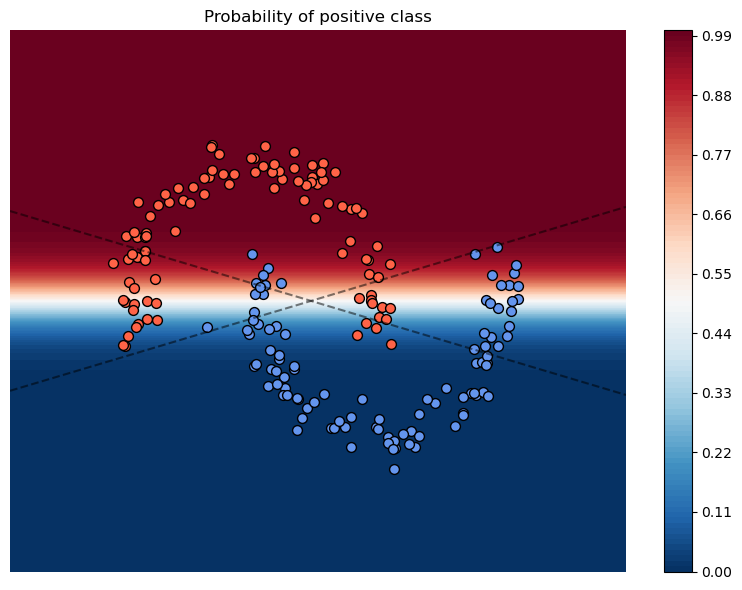

In [61]:
model_test = MulticlassLogisticRegression_Test3()
plot_model_probs_with_component_lines(model_test, dataset.positive_data, dataset.negative_data, model_test.weight_matrix.weight.detach().numpy(), model_test.weight_matrix.bias.detach().numpy(), 2)
print_model_params(model_test)

Without ReLU, the two Linear layers collapse into a single linear transformation:

$$
\text{Output} = W_2(W_1 x + b_1) + b_2 = (W_2 W_1) x + (W_2 b_1 + b_2)
$$

This is still just a linear function of the input, and the decision boundary (where the output logits for two classes are equal) will be defined by a linear equation—i.e., a straight line in 2D.

So, in effect, you’re just doing one big matrix multiply with a bias—like a single-layer linear classifier.

We need to break up the linearity of multiplying these matrices by injecting a simple element-wise non-linear function:

Let $\textrm{ReLU}(z)$ denote the **rectified linear unit** (ReLU) function where
$$
\textrm{ReLU}(z)=\max\{0, z\}
$$
simply thresholds negative numbers to zero. This function is non-linear and allows us to create a now function:
$$
f(x) = z = W_2\textrm{ReLU}(W_1x).
$$

When you introduce ReLU, it applies an element-wise non-linearity between the two linear layers. So now, your network looks like this:

$$
x_1 = W_1 x + b_1 \
x_2 = \text{ReLU}(x_1) \
z = W_2 x_2 + b_2
$$

The ReLU “bends” the input space by zeroing out negative components of the intermediate vector. Because of this:
* The network can behave differently in different regions of the input space.
* It becomes a piecewise linear function instead of a single linear one.
* These different linear regions (from ReLU activating or deactivating certain nodes) combine to form non-linear, curved decision boundaries.

This is what allows neural networks to learn complex shapes for classification—even though each layer is linear, the ReLU introduces crucial non-linear behavior.

Let's return to our dual half-moon example and see how good we can classify: 

Text(0, 0.5, 'Accuracy')

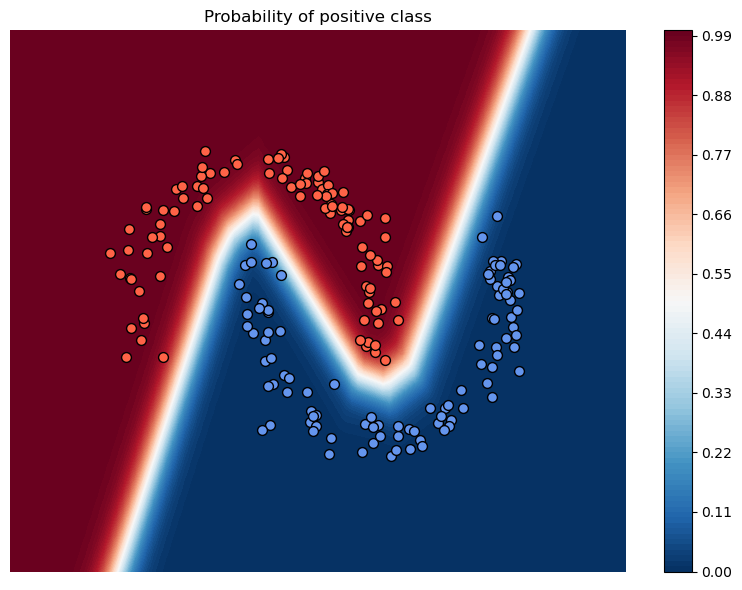

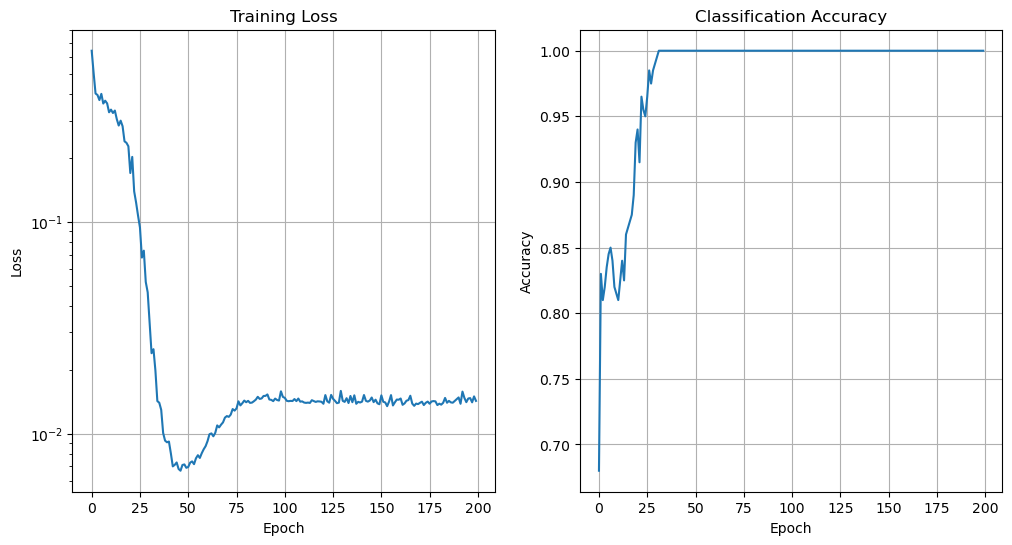

In [13]:
class TwoLayerModel(nn.Module):
    def __init__(self, N, L, M):
        super().__init__()
        self.N = N # input dimension
        self.M = M # number of classes
        self.weight_matrix1 = nn.Linear(N, L, bias=True) # N input dimensions, L hidden dimensions
        self.weight_matrix2 = nn.Linear(L, M)

    def forward(self, x):
        x = self.weight_matrix1(x)
        x = torch.nn.functional.relu(x)
        z = self.weight_matrix2(x)
        return z

# loss function, model, and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean') # cross-entropy loss, use mean of loss
lr = 1e-2 # learning rate
M = 2 # two classes
N = 2 # data is two-dimensional
L = 8 # number of hidden features
fancy_new_model = TwoLayerModel(N, L, M)
optimizer = torch.optim.SGD(fancy_new_model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-3) 

# create training dataloader
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# training loop
n_epoch = 200
loss_values, accuracies = [], []
for n in range(n_epoch):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # zero out gradients
        optimizer.zero_grad()
        # pass batch to model
        predictions = fancy_new_model(x_batch)
        # calculate loss
        loss = criterion(predictions, y_batch)
        # backpropagate and update
        loss.backward() # backprop
        optimizer.step()
        # logging to update epoch_loss (add loss value) and epoch_acc (add current batch accuracy)
        epoch_loss += loss.item()
        epoch_acc += multiclass_model_accuracy(fancy_new_model, x_batch, y_batch)
    loss_values.append(epoch_loss/len(train_loader))
    accuracies.append(epoch_acc/len(dataset))
    
# plot model probabilities
plot_model_probs(fancy_new_model, dataset.positive_data, dataset.negative_data)
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

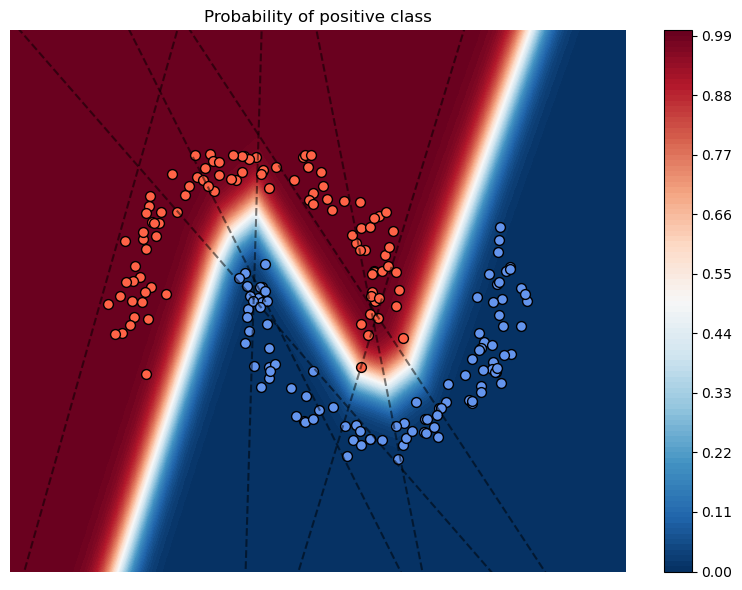

In [25]:
plot_model_probs_with_component_lines(fancy_new_model, dataset.positive_data, dataset.negative_data, fancy_new_model.weight_matrix1.weight.detach().numpy(), fancy_new_model.weight_matrix1.bias.detach().numpy(), L)

In [16]:
for name, param in fancy_new_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

weight_matrix1.weight tensor([[ 1.6706e+00,  9.1917e-01],
        [-7.3138e-02,  2.2710e-02],
        [-3.1482e-03, -1.4357e-02],
        [ 2.2412e+00,  4.8141e-01],
        [ 9.1132e-01,  8.7125e-01],
        [-3.5876e+00,  1.1679e-01],
        [-1.5938e+00, -1.1474e+00],
        [ 1.9639e+00, -6.5932e-01]])
weight_matrix1.bias tensor([-0.1165, -0.0924, -0.0516, -2.0563,  0.0074, -0.0811,  1.4361, -1.9892])
weight_matrix2.weight tensor([[-1.3160,  0.0051,  0.0047,  2.1710, -0.8853, -2.5547,  1.7090,  2.0016],
        [ 1.3507, -0.0079, -0.0138, -2.1563,  0.8662,  2.5173, -1.7040, -2.0180]])
weight_matrix2.bias tensor([ 0.0554, -0.0345])


## Activation Functions

We commonly refer to these element-wise non-linearities as **activation functions**. Examples of activation functions, including ReLU, are as follows:

* [Rectified Linear Unit (ReLU)](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU):
$$
\sigma(z) = \begin{cases}
z,~&z\geq 0\\
0,~&z<0
\end{cases}=\max\{0, z\}
$$
* [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid):
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$
* [Hyperbolic Tangent (Tanh)](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh):
$$
\sigma(z) = \frac{e^z-e^{-z}}{e^{z}+e^{-z}}
$$
* [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU)
$$
\sigma_\tau(z) = \begin{cases}
z,~&z\geq 0\\
-\tau z~&z < 0
\end{cases}
$$
* and many more may be [found here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

## Multi-layer Perceptron

The model we created above is known as a two-layer perceptron. One individual weight matrix that transforms an input vector to another vector is commonly referred to as a **perceptron**. The concatenation of multiple perceptrons separated by non-linear activation functions is known as a **multi-layer perceptron** (MLP) or **fully-connected network** (we will skip the abbreviation since FCN is commonly used for something else in machine learning).

Multi-layer perceptrons are our first example of a **deep neural network** or **deep net** in this course! As mentioned earlier, we may stack arbitrarily many perceptrons and non-linearities to form deeper neural nets. Each **layer** has an input and output dimension that is a **hyperparameter** of the **model architecture**. Every layer that is followed by an activation function is referred to as a **hidden layer** as it separates the inputs from the outputs of the model. The below figure depicts a three-layer MLP with two hidden layers. Each arrow represents a weight multiplying one entry of an input vector. The result of this multiplication is passed to a node in the next layer where the result at each node is the summation of all incoming arrows followed by an activation function.

<div>
<center><img src="./img/mlp-figure.jpg" width="800"/> </center>
</div>

Let's create another example MLP.

## Larger Deepnet: Image Classification with MLP

To conclude this lecture, we will experiment with creating MLP models to perform image classification with the [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This dataset contains $28\times 28$ grayscale images of clothing sorted into ten classes. We have created a dataset to download the data from the ``torchvision`` package (which you may need to install, as well as the ``tqdm`` package for tracking progress bars during training). 

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



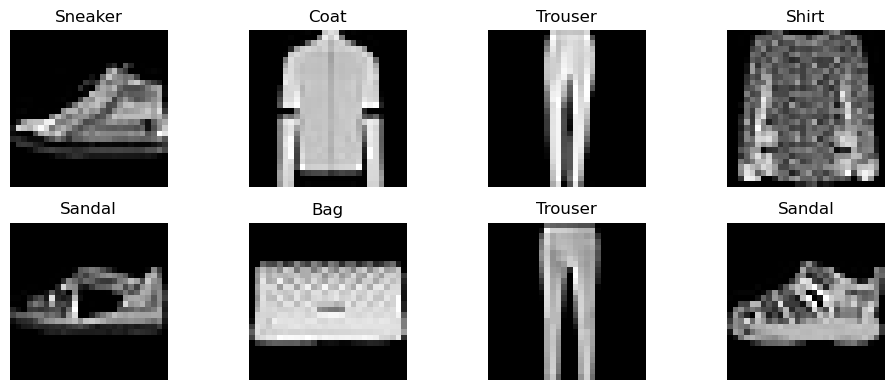

In [62]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a transform to convert the data to tensor and normalize it
transform = transforms.ToTensor()

# Download the FashionMNIST training dataset
fashion_mnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader to iterate through the dataset
data_loader = torch.utils.data.DataLoader(fashion_mnist, batch_size=8, shuffle=True)

# Define class labels for FashionMNIST
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Get a batch of data
images, labels = next(iter(data_loader))

# Plot the images
plt.figure(figsize=(10, 4))
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(class_labels[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn

class MyMLPModel(nn.Module):
    # add hidden dimension sizes to constructor as you see fit!
    def __init__(self, input_dim, h1, output_dim, activation_fn):
        super().__init__()
        # create layers using nn.Linear(input_dimension, output_dimension) objects
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, output_dim)
        # assign non-linear activation function to class
        self.activation = activation_fn
    
    def forward(self, x):
        # implement forward pass
        x = self.fc1(x)
        x = self.activation(x)
        z = self.fc2(x)
        return z
        

100.0%


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100.0%


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100.0%


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100.0%


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [07:12<00:00,  1.44s/it]


Text(0.5, 0, 'Epoch')

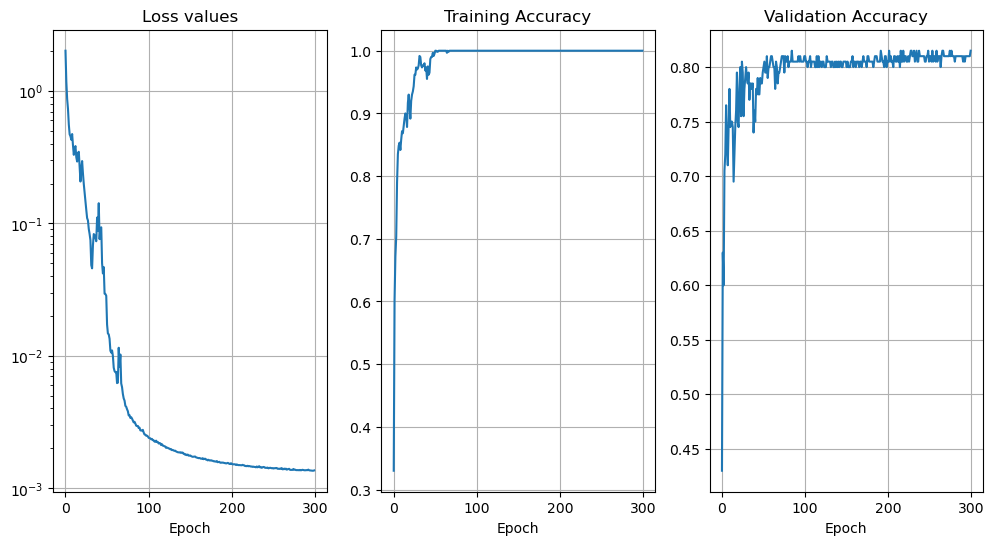

In [8]:
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

# set up data
class FashionMNIST(Dataset):
    def __init__(self):
        self.data = torchvision.datasets.FashionMNIST(root='./',
                                            download=True,
                                            train=True,
                                            transform=transforms.Compose([transforms.ToTensor()]))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image.reshape(-1), label

N = 1000
N_train = 600
N_val = 200
N_test = 200
dataset = FashionMNIST()
indices = np.random.choice(np.arange(len(dataset)), size=N, replace=False)
np.random.shuffle(indices)
train_indices = indices[:N_train]
val_indices = indices[N_train:N_train+N_val]
test_indices = indices[N_train+N_val]

batch_size = 8
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

# initialize model
input_dim = 784 # dimension of images after being vectorized
h1 = 128
output_dim = 10 # number of classes
activation_fn = nn.ReLU()
model = MyMLPModel(input_dim, h1, output_dim, activation_fn) # fill this is based on your implementation!

# initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-4)

# logging info
loss_values, train_accuracies, val_accuracies = [], [], []
n_epoch = 300 # set this value
for n in tqdm(range(n_epoch)):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # zero out gradients
        optimizer.zero_grad()
        # pass batch to model, no need to worry about using squeeze/unsqueeze now
        predictions = model(x_batch)
        # calculate loss
        loss = criterion(predictions, y_batch)
        # backpropagate and update
        loss.backward() # backprop
        optimizer.step()
        # logging to update epoch_loss (add loss value) and epoch_acc (add current batch accuracy)
        epoch_loss += loss.item()
        epoch_acc += multiclass_model_accuracy(model, x_batch, y_batch)

    loss_values.append(epoch_loss/len(train_loader))
    train_accuracies.append(epoch_acc/N_train)
    # validation performance
    val_acc = 0
    for x_batch, y_batch in val_loader:
        # don't compute gradients since we are only evaluating the model
        with torch.no_grad():
            # validation batch accuracy
            val_acc += multiclass_model_accuracy(model, x_batch, y_batch)
    val_accuracies.append(val_acc/N_val)

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Loss values')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_accuracies)
plt.grid(True)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_accuracies)
plt.grid(True)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')

## There's a problem

Deep nets seem pretty great right? So why do we need anything more? Well.....

**Issue with fully connected layers:**

- Suppose the input is an image of size $256 \times 256$
- Let the output of this layer have identical size
- How many weights are necessary?

$$
2^{32} = 4,294,967,296
$$

- That's as big as a lot of smaller LLMs and I can promise you it can't do nearly as much... Better methods needed  ... which we'll discuss next time.  

## That's all for today

- Homework and midterm grades will be posted in the next couple days. 
- Project description will be posted within the week.
- Will talk about convolutional neural nets next time. 